In [2]:
import os
import numpy as np
import sep
import seaborn 
import pandas as pd
from astropy.io import fits
from astropy.io import ascii
import matplotlib.pyplot as plt 

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
%matplotlib inline

In [4]:
data_path = os.path.abspath('../data/extract_test/stellar/CSTAR/')

In [5]:
images_path = os.path.join(data_path, 'images')
master_Ryan = os.path.join(images_path, 'master10_wcs.fits')

In [6]:
mR = fits.getdata(master_Ryan)

In [7]:
data = mR.byteswap().newbyteorder()

In [8]:
bkg = sep.Background(data)

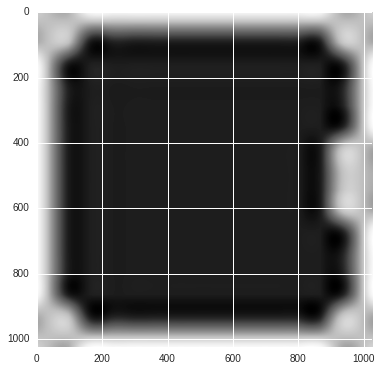

In [9]:
fig = plt.figure(figsize=(6,6))
plt.imshow(bkg.back())

In [10]:
img = data - bkg

In [11]:
thresh = 100.*bkg.globalrms
sources = sep.extract(img, thresh)

In [12]:
obj = pd.DataFrame(sources)

In [13]:
stars = os.path.join(data_path, 'cats/stars.dat') 
stars = ascii.read(stars, names= ['cstarid','x','y','imag'])
stars = stars.to_pandas()
stars['objID'] = range(len(stars))

In [14]:
import astroML.crossmatch as cx

## Right

In [15]:
S = np.array([stars['x'], stars['y']]).T
O = np.array([obj['x'], obj['y']]).T

In [16]:
distr, indr  = cx.crossmatch(S, O, max_distance=2.)

In [17]:
matchsr = ~np.isinf(distr)

## Left

In [18]:
distl, indl  = cx.crossmatch(O, S, max_distance=2.)

In [19]:
matchsl = ~np.isinf(distl)

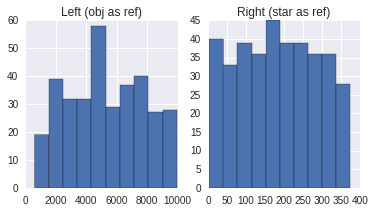

In [20]:
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.hist(indl[matchsl])
plt.title('Left (obj as ref)')
plt.subplot(122)
plt.hist(indr[matchsr])
plt.title('Right (star as ref)')
plt.show()

(array([ 285.,   34.,    9.,    3.,    3.,    1.,    4.,    1.,    0.,    1.]),
 array([ 0.01081772,  0.2084311 ,  0.40604448,  0.60365786,  0.80127124,
         0.99888462,  1.196498  ,  1.39411138,  1.59172476,  1.78933814,
         1.98695152]),
 <a list of 10 Patch objects>)

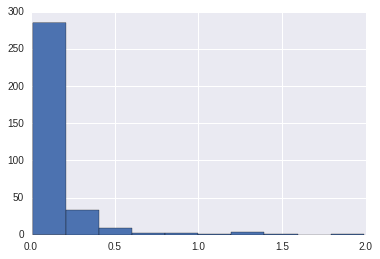

In [21]:
plt.hist(distl[matchsl].flatten())

Now the matchs are from left to **RIGHT**:
* matchs between the objects detected and stars in the catalog, using as reference *star catalog*.

right to **LEFT**
* matchs between stars in the catalog and objects using as reference *objects* detected

In [22]:
objID = np.zeros_like(O[:,0]) -1
CSTARID = np.zeros_like(O[:,0]) -1
for i in range(len(O)):
    if distl[i] != np.inf: 
        dist_o = distl[i]
        ind_o  = indl[i]
        # now ind is a star number
        # lets see if that star has matched the same obj
        if distr[ind_o] != np.inf:
            dist_s = distr[ind_o]
            ind_s = indr[ind_o]
            if ind_s == i:
                objID[i] = ind_o  
                CSTARID[i] = stars['cstarid'][ind_o]

In [23]:
obj['objID'] = objID
obj['cstarid'] = CSTARID

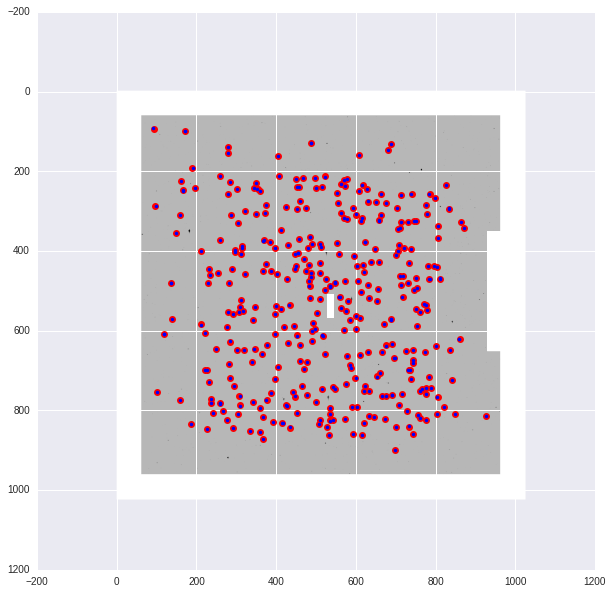

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(data)
f = obj['objID'] > 0
plt.plot(obj['x'][f], obj['y'][f], 'ro')
plt.plot(stars['x'][matchsr], stars['y'][matchsr], 'b.')

In [28]:
print sum(objID > 0.), sum(objID < 0.)

341 40
